# Title: Post-modeling analysis

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Accuracy comparison

In [2]:
# Read data saved in previous notebooks
%store -r baseline_dummy_score
%store -r baseline_logreg_score
%store -r baseline_knn_score

%store -r test_score_logreg
%store -r test_score_logreg_pca

%store -r test_score_knn
%store -r test_score_knn_smote
%store -r test_score_knn_pca

%store -r test_score_rf
%store -r test_score_rf_smote
%store -r test_score_rf20

In [3]:
# Collect the data in lists
test_accuracy=[baseline_dummy_score, baseline_logreg_score, baseline_knn_score,
              test_score_logreg, test_score_logreg_pca,
              test_score_knn, test_score_knn_smote, test_score_knn_pca,
              test_score_rf, test_score_rf_smote, test_score_rf20]
models=['baseline_dummy','baseline_logreg', 'baseline_knn',
        'logreg','logreg_pca',
        'knn', 'knn_smote', 'knn_pca',
        'rf', 'rf_smote', 'rf20']

In [4]:
# Final comparison in a DataFrame
comparison=pd.DataFrame(models, columns=['model'])
comparison['test_accuracy']=[round(num, 3) for num in test_accuracy]
comparison

,model,test_accuracy
0,baseline_dummy,66.667
1,baseline_logreg,80.180
2,baseline_knn,81.081
3,logreg,80.180
4,logreg_pca,78.378
5,knn,83.784
6,knn_smote,80.180
7,knn_pca,81.081
8,rf,79.279
9,rf_smote,80.180


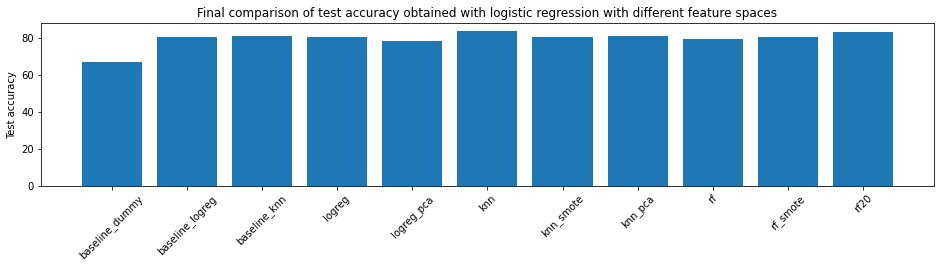

In [5]:
# Draw a bar chart
fig, axes = plt.subplots(figsize = (16,3))

plt.bar(comparison["model"], comparison["test_accuracy"])

plt.ylabel('Test accuracy')
plt.xticks(rotation = 45)
plt.title("Final comparison of test accuracy obtained with logistic regression with different feature spaces")
plt.show()

**Comment:** The knn classfier gives the highest accuracy of 83.78%. When using SMOTE to oversample the smallest class, the accuracy drops by few % (both in the knn and the rf classifers). Similary, when reducing the dimensions of data with the PCA, the accuracy drops when compared to models fit on the data with all features, but the drop is not drastic, only few %. 

# Predictions

In [6]:
%store -r y_te

%store -r y_te_preds_logreg
%store -r y_te_preds_logreg_pca

%store -r y_te_preds_knn
%store -r y_te_preds_knn_smote
%store -r y_te_preds_knn_pca

%store -r y_te_preds_rf
%store -r y_te_preds_rf_smote
%store -r y_te_preds_rf20

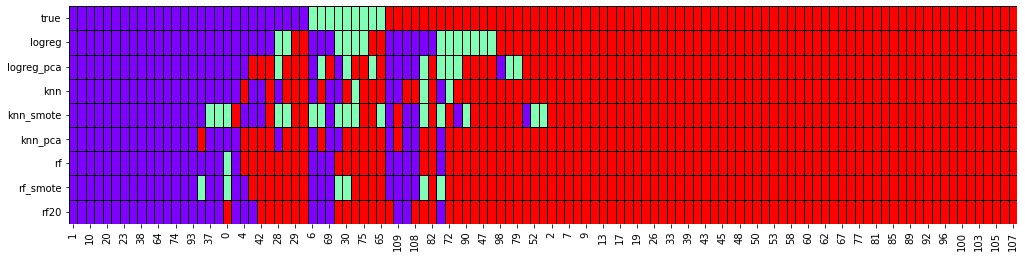

In [7]:
# Aggregate model predictions and true values in a DataFrame
prediction_grid = pd.DataFrame(
    np.array(np.vstack((y_te, y_te_preds_logreg, y_te_preds_logreg_pca,
                        y_te_preds_knn, y_te_preds_knn_smote, y_te_preds_knn_pca,
                       y_te_preds_rf, y_te_preds_rf_smote, y_te_preds_rf20))),
    index=["true", 'logreg','logreg_pca',
        'knn', 'knn_smote', 'knn_pca',
        'rf', 'rf_smote', 'rf20'])

# Sort the predictions per model (from top to bottom)
prediction_grid = prediction_grid.T.sort_values(
    by=prediction_grid.index.tolist()).T

# Plot predictions in a horizontal image
plt.figure(figsize=(17, 4))
sns.heatmap(prediction_grid, cmap="rainbow", linewidths=0.9, linecolor="black", cbar=False)
plt.show()

**Comment:**
- The logistic regression fit on data with all features misclassfied the smallest number of the post-COVID patients (only 4 out of 28). Two of them were misclassfied as post acute phase patients and two of them as being in the acute phase of infection. The model was able to correctly classify 4 out of 9 post acute phase patients. The model discalssified 13 patients being in the acute phase of infection, much more than other models, for example the random forest or knn fit on PCA-reduced data (both of them misclassfied only 4 patients bing in the acute phase).
- The models that were fit on data where the smallest class was synthetically oversampled, tend to predict more patients as being in the post acute phase of infection, but the predictions are most of the time incorrect. 

# Probabilities of misclassfied patients

In [8]:
%store -r prob_logreg
%store -r prob_logreg_pca

%store -r prob_knn
%store -r prob_knn_smote
%store -r prob_knn_pca

%store -r prob_rf
%store -r prob_rf_smote
%store -r prob_rf20

In [9]:
probabilities=[prob_logreg, prob_logreg_pca,
              prob_knn, prob_knn_smote, prob_knn_pca,
              prob_rf, prob_rf_smote, prob_rf20]
titles=["Probabilities logreg",
       "Probabilities logreg PCA",
       "Probabilities knn",
       "Probabilities knn SMOTE",
       "Probabilities knn PCA",
        "Probabilities rf",
       "Probabilities rf SMOTE",
       "Probabilities rf 20"]

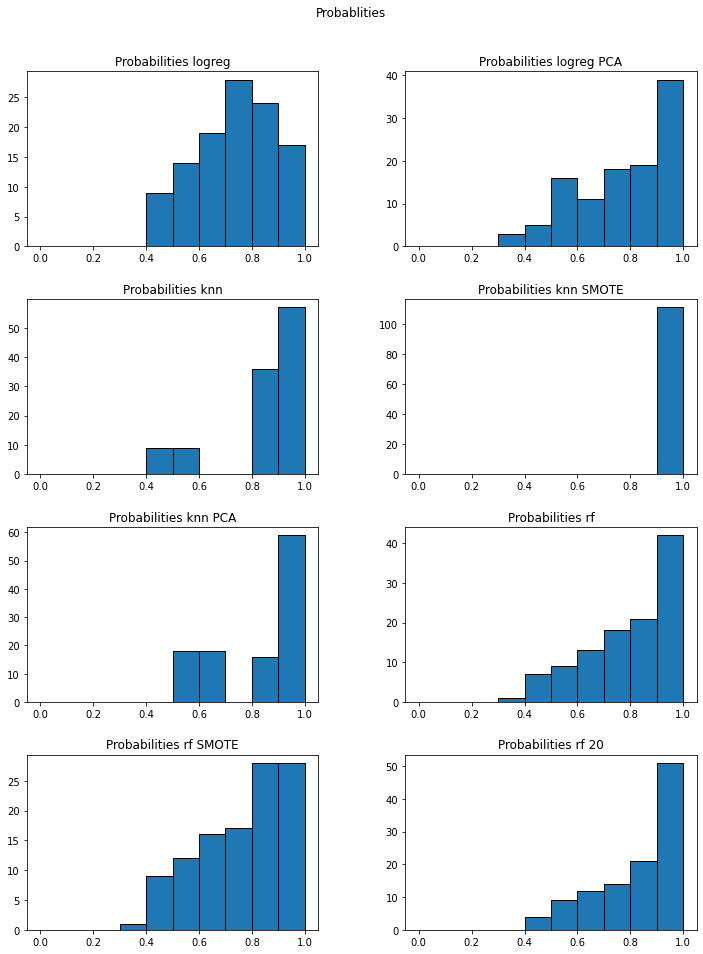

In [10]:
# Take the 20 with the lowest p_value

fig, axes = plt.subplots(nrows = 4,
                        ncols = 2,
                        figsize = (12,15),
                        gridspec_kw = {"wspace": 0.3,  # Sets the width of padding between subplots (is a fraction of the Axes width)
                                       "hspace": 0.3,
                                        "width_ratios": [ 1, 1] # Sets relative width ratios between subplots 
                                       })

for i, ax in zip(range(0, len(probabilities)), axes.ravel()):
    
    # Plot the box plot
    ax.hist(probabilities[i].max(axis=1), bins=np.arange(0, 1.01, 0.1), edgecolor = "black")
    ax.set_title(titles[i])
    
fig.suptitle("Probablities") 
fig.subplots_adjust(top=0.92)
plt.show()

**Comment:** Some of the models are very sure about their predictions and some others less. For example, the range of probabilities of how likely the patients belong to their target classes is quite wide, when compared for example with the knn classfier or the random forest classfier fit on data with only 20 features. 

# Analysis of misclassfied patients

## Post-COVID patients misclassified as being in the acute phase

### k-NN classfier

In [11]:
from IPython.display import display
cols=['knn']

for i in range(0,len(cols)):
    
    true_logreg_compare=prediction_grid.T[['true',cols[i]]]
    true_logreg_compare['prob']=probabilities[i].max(axis=1)
    true_logreg_compare['correct']=(true_logreg_compare['true']==true_logreg_compare[cols[i]]).astype(int)
    display(true_logreg_compare[true_logreg_compare['correct']==0])

,true,knn,prob,correct
4,0,2,0.778711,0
35,0,2,0.796797,0
102,0,2,0.610309,0
29,0,2,0.632012,0
87,0,2,0.461512,0
6,1,0,0.622771,0
66,1,2,0.722182,0
69,1,0,0.649029,0
25,1,0,0.715538,0
30,1,2,0.892482,0


In [12]:
true_logreg_compare[true_logreg_compare['correct']==0].index

Int64Index([4, 35, 102, 29, 87, 6, 66, 69, 25, 30, 75, 80, 65, 31, 109, 41, 15,
            72],
           dtype='int64')

In [13]:
data_ohe = pd.read_csv("data_ohe.csv") # One-hot encoded
print('Data one-hot encoded shape', data_ohe.shape)
data_ohe.head()

Data one-hot encoded shape (368, 152)


,sample_id,group,age,Alanine,Creatine,Creatinine,Glutamine,Glycine,Histidine,Isoleucine,...,severity_0,severity_1,severity_2,severity_3,sex_0,sex_1,age_cat_0,age_cat_1,age_cat_2,age_cat_3
0,6,2,72,0.411,0.016,0.088,0.705,0.274,0.063,0.077,...,1,0,0,0,0,1,0,0,1,0
1,7,2,89,0.379,0.018,0.069,0.696,0.538,0.034,0.062,...,1,0,0,0,1,0,0,0,0,1
2,9,2,82,0.362,0.058,0.117,0.657,0.311,0.054,0.054,...,1,0,0,0,1,0,0,0,1,0
3,19,2,56,0.394,0.007,0.100,0.783,0.227,0.067,0.084,...,1,0,0,0,0,1,0,1,0,0
4,20,2,87,0.224,0.122,0.155,0.452,0.220,0.055,0.033,...,1,0,0,0,0,1,0,0,0,1


In [14]:
# Retrieve the original index (in prediction_grid y is indexed from 0 to len(y_te), here we need the index compatible with data_ohe)
original_index=y_te.index[[4, 35, 102, 29, 87]]

# Check the patients in the group post-COVID, who were misclassified as being in the acute phase of the COVID infection.
data_ohe_mis=data_ohe.iloc[list(original_index)]

# Check the categroical features of patients post-COVID, who were misclassified as being in the acute phase of the COVID infection.
%store -r col_float64
data_ohe_mis_cat=data_ohe_mis.loc[:,~data_ohe_mis.columns.isin(col_float64)]
data_ohe_mis_cat

,sample_id,group,age,severity_0,severity_1,severity_2,severity_3,sex_0,sex_1,age_cat_0,age_cat_1,age_cat_2,age_cat_3
313,45,0,63,0,0,1,0,0,1,0,1,0,0
332,201,0,80,0,0,1,0,0,1,0,0,1,0
365,278,0,72,0,0,0,1,0,1,0,0,1,0
293,71,0,94,0,1,0,0,0,1,0,0,0,1
286,4,0,93,0,1,0,0,1,0,0,0,0,1


**Comment:** The two post-COVID patients that were misclassfied as being in the acute phase of infection with high probablity are two patients with severity_2 (moderate severity of symptoms). One another misclassified had severe symptoms in the acute phase. The two last ones were assigned the label group 2 instead the correct one group 0 with the probability of 63% and 46%. Those patients had mild symptoms, however they are aged 94 and 93, which may play a role in the recovery speed. 

### Logistic regression classfier

In [15]:
from IPython.display import display
cols=['logreg']

for i in range(0,len(cols)):
    
    true_logreg_compare=prediction_grid.T[['true',cols[i]]]
    true_logreg_compare['prob']=probabilities[i].max(axis=1)
    true_logreg_compare['correct']=(true_logreg_compare['true']==true_logreg_compare[cols[i]]).astype(int)
    display(true_logreg_compare[true_logreg_compare['correct']==0])

,true,logreg,prob,correct
28,0,1,0.826752,0
102,0,1,0.610309,0
29,0,2,0.632012,0
87,0,2,0.461512,0
6,1,0,0.622771,0
66,1,0,0.722182,0
69,1,0,0.649029,0
80,1,2,0.526084,0
65,1,2,0.820065,0
31,2,0,0.794100,0


In [16]:
true_logreg_compare[true_logreg_compare['correct']==0].index

Int64Index([ 28, 102,  29,  87,   6,  66,  69,  80,  65,  31, 109,  94, 108,
             41,  82,  15,  72,  11,  90,  21,  47, 110],
           dtype='int64')

In [17]:
# Retrieve the original index (in prediction_grid y is indexed from 0 to len(y_te), here we need the index compatible with data_ohe)
original_index=y_te.index[[28, 102, 29, 87]]

# Check the patients in the group post-COVID, who were misclassified as being in the acute phase of the COVID infection.
data_ohe_mis=data_ohe.iloc[list(original_index)]

# Check the categroical features of patients post-COVID, who were misclassified as being in the acute phase of the COVID infection.
%store -r col_float64
data_ohe_mis_cat=data_ohe_mis.loc[:,~data_ohe_mis.columns.isin(col_float64)]
data_ohe_mis_cat

,sample_id,group,age,severity_0,severity_1,severity_2,severity_3,sex_0,sex_1,age_cat_0,age_cat_1,age_cat_2,age_cat_3
366,279,0,79,0,0,0,1,0,1,0,0,1,0
365,278,0,72,0,0,0,1,0,1,0,0,1,0
293,71,0,94,0,1,0,0,0,1,0,0,0,1
286,4,0,93,0,1,0,0,1,0,0,0,0,1


**Comment:** In this case, two of the four misclassified patients had severe symptoms, which may have caused longer-lasting change in their metabolome/lipidome and therefore they are more similar to patients in the acute phase of infection, even after a few weeks time, and thus the model classifies them as such. The two other misclassified patients are the ones that were also misclassfied by the k-NN, where their age may play a role in this misclassfication. 

**Plot the most important logistic regression features** (with the highest coefficient) and overlap with data of the 4 post-COVID patients misclassfied as being in the acute phase and compare with data of all other patients:

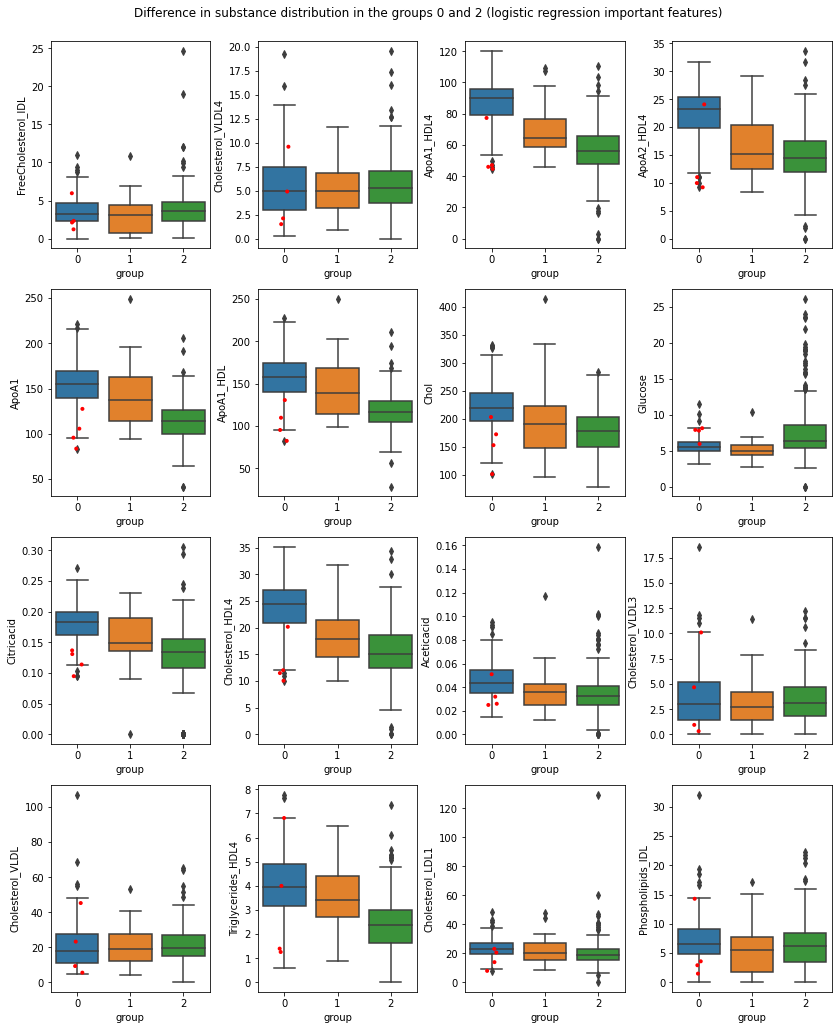

In [18]:
%store -r post_covid_feat
%store -r col_float64

# Take 16 most important (numerical only) features important for predicting the post-COVID category
post_covid_feat_list=list(set(post_covid_feat[:18]).intersection(col_float64))

fig, axes = plt.subplots(nrows = 4,
                        ncols = 4,
                        figsize = (14,16),
                        gridspec_kw = {"wspace": 0.3,  # Sets the width of padding between subplots (is a fraction of the Axes width)
                                       "hspace": 0.2,
                                        "width_ratios": [ 1, 1, 1, 1] # Sets relative width ratios between subplots 
                                       })

for feat, ax in zip(range(0, 16), axes.ravel()):
    
    # Plot the box plot
    sns.boxplot(x=data_ohe["group"], y=data_ohe[post_covid_feat_list[feat]], ax=ax)
    sns.stripplot(x=data_ohe["group"], y=data_ohe_mis[post_covid_feat_list[feat]], size=4, color="red", ax=ax)

fig.suptitle("Difference in substance distribution in the groups 0 and 2 (logistic regression important features)") 
fig.subplots_adjust(top=0.95)
plt.show()

**Comment:** The misclassfied points are outliers in the distributions of several of the substances (features) that had high coefficents for predicting the post-COVID group in the logistic regression. 

## Post acute phase patients misclassified as being in the acute phase

### k-NN classfier

In [19]:
# Retrieve the original index (in prediction_grid y is indexed from 0 to len(y_te), here we need the index compatible with data_ohe)
original_index=y_te.index[[66, 30, 75, 80, 65]]

# Check the patients in the group post-COVID, who were misclassified as being in the acute phase of the COVID infection.
data_ohe_mis=data_ohe.iloc[list(original_index)]

# Check the categroical features of patients post-COVID, who were misclassified as being in the acute phase of the COVID infection.
%store -r col_float64
data_ohe_mis_cat=data_ohe_mis.loc[:,~data_ohe_mis.columns.isin(col_float64)]
data_ohe_mis_cat

,sample_id,group,age,severity_0,severity_1,severity_2,severity_3,sex_0,sex_1,age_cat_0,age_cat_1,age_cat_2,age_cat_3
248,13,1,51,1,0,0,0,1,0,0,1,0,0
263,97,1,93,0,1,0,0,1,0,0,0,0,1
250,17,1,80,1,0,0,0,0,1,0,0,1,0
246,10,1,90,1,0,0,0,1,0,0,0,0,1
264,395,1,86,0,1,0,0,1,0,0,0,0,1


### Logistic regression classfier

In [20]:
# Retrieve the original index (in prediction_grid y is indexed from 0 to len(y_te), here we need the index compatible with data_ohe)
original_index=y_te.index[[80, 65]]

# Check the patients in the group post-COVID, who were misclassified as being in the acute phase of the COVID infection.
data_ohe_mis=data_ohe.iloc[list(original_index)]

# Check the categroical features of patients post-COVID, who were misclassified as being in the acute phase of the COVID infection.
%store -r col_float64
data_ohe_mis_cat=data_ohe_mis.loc[:,~data_ohe_mis.columns.isin(col_float64)]
data_ohe_mis_cat 

,sample_id,group,age,severity_0,severity_1,severity_2,severity_3,sex_0,sex_1,age_cat_0,age_cat_1,age_cat_2,age_cat_3
246,10,1,90,1,0,0,0,1,0,0,0,0,1
264,395,1,86,0,1,0,0,1,0,0,0,0,1


**Comment:** Here again, the two misclassfied patients are in the age category 3 (>85) that may have affected them being classfied as being in the acute phase rather than post-acute. Their metabolome/lipidome may be more similar to patients in the acute phase of infection. 

## Patients in the acute phase of infection misclassified as Post-COVID

### k-NN classifier

In [21]:
# Retrieve the original index (in prediction_grid y is indexed from 0 to len(y_te), here we need the index compatible with data_ohe)
original_index=y_te.index[[31, 109, 15]]

# Check the patients in the group post-COVID, who were misclassified as being in the acute phase of the COVID infection.
data_ohe_mis=data_ohe.iloc[list(original_index)]

# Check the categroical features of patients post-COVID, who were misclassified as being in the acute phase of the COVID infection.
%store -r col_float64
data_ohe_mis_cat=data_ohe_mis.loc[:,~data_ohe_mis.columns.isin(col_float64)]
data_ohe_mis_cat 

,sample_id,group,age,severity_0,severity_1,severity_2,severity_3,sex_0,sex_1,age_cat_0,age_cat_1,age_cat_2,age_cat_3
24,361,2,50,1,0,0,0,0,1,1,0,0,0
13,254,2,59,1,0,0,0,0,1,0,1,0,0
36,39,2,74,0,1,0,0,1,0,0,0,1,0


### Logistic regression 

In [22]:
# Retrieve the original index (in prediction_grid y is indexed from 0 to len(y_te), here we need the index compatible with data_ohe)
original_index=y_te.index[[31, 109,  94, 108, 41,  82]]

# Check the patients in the group post-COVID, who were misclassified as being in the acute phase of the COVID infection.
data_ohe_mis=data_ohe.iloc[list(original_index)]

# Check the categroical features of patients post-COVID, who were misclassified as being in the acute phase of the COVID infection.
%store -r col_float64
data_ohe_mis_cat=data_ohe_mis.loc[:,~data_ohe_mis.columns.isin(col_float64)]
data_ohe_mis_cat 

,sample_id,group,age,severity_0,severity_1,severity_2,severity_3,sex_0,sex_1,age_cat_0,age_cat_1,age_cat_2,age_cat_3
24,361,2,50,1,0,0,0,0,1,1,0,0,0
13,254,2,59,1,0,0,0,0,1,0,1,0,0
38,110,2,43,0,1,0,0,1,0,1,0,0,0
219,458,2,53,0,0,1,0,0,1,0,1,0,0
2,9,2,82,1,0,0,0,1,0,0,0,1,0
42,210,2,53,0,1,0,0,1,0,0,1,0,0


**Comment:** Three out of the six misclassfied patients were asymptomatic in the acute phase. Five out of six are in age categories 0 and 1.

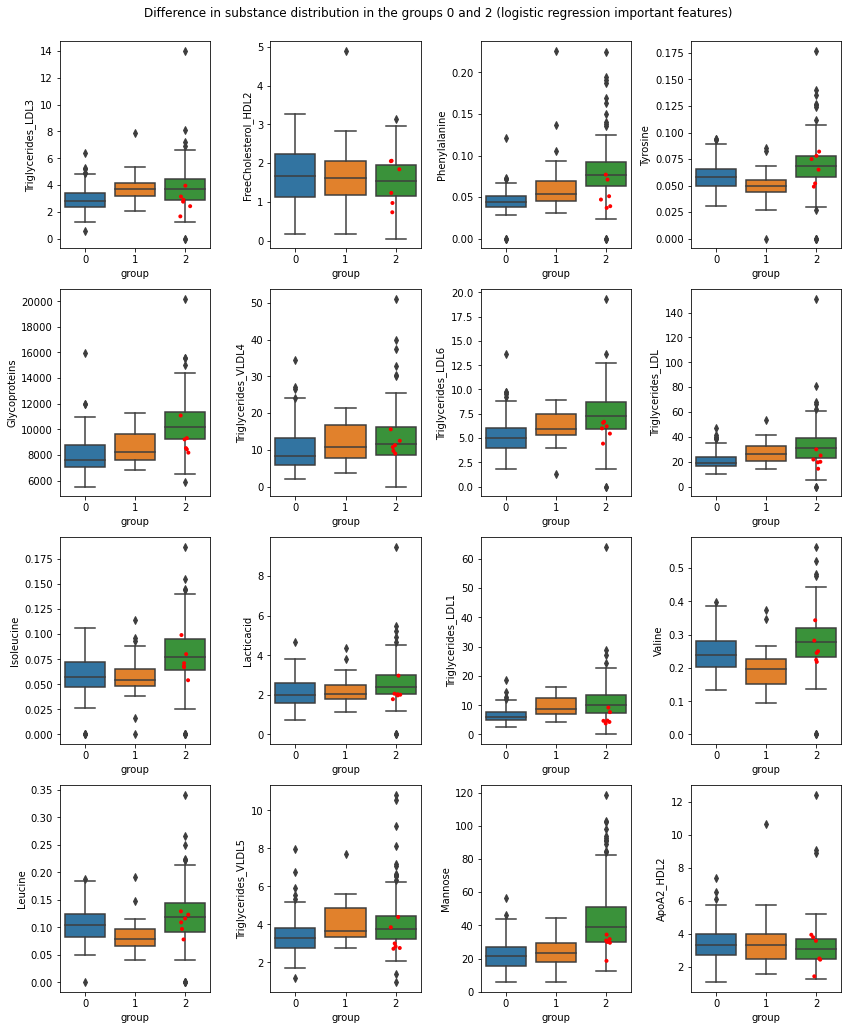

In [23]:
%store -r acute_feat
%store -r col_float64

# Take 16 most important (numerical only) features important for predicting the acute phase category
acute_feat_list=list(set(acute_feat[:19]).intersection(col_float64))

fig, axes = plt.subplots(nrows = 4,
                        ncols = 4,
                        figsize = (14,16),
                        gridspec_kw = {"wspace": 0.4,  # Sets the width of padding between subplots (is a fraction of the Axes width)
                                       "hspace": 0.2,
                                        "width_ratios": [ 1, 1, 1, 1] # Sets relative width ratios between subplots 
                                       })

for feat, ax in zip(range(0, 16), axes.ravel()):
    
    # Plot the box plot
    sns.boxplot(x=data_ohe["group"], y=data_ohe[acute_feat_list[feat]], ax=ax)
    sns.stripplot(x=data_ohe["group"], y=data_ohe_mis[acute_feat_list[feat]], size=4, color="red", ax=ax)

fig.suptitle("Difference in substance distribution in the groups 0 and 2 (logistic regression important features)") 
fig.subplots_adjust(top=0.95)
plt.show()

**Comment:** The misclassfied points are outliers in the distributions of several of the substances (features) that had high coefficents for predicting the acute phase group in the logistic regression. 

## Patients in the acute phase of infection misclassified as being in _post acute phase_ of infection

### k-NN classfier

In [24]:
# Retrieve the original index (in prediction_grid y is indexed from 0 to len(y_te), here we need the index compatible with data_ohe)
original_index=y_te.index[[41, 72]]

# Check the patients in the group post-COVID, who were misclassified as being in the acute phase of the COVID infection.
data_ohe_mis=data_ohe.iloc[list(original_index)]

# Check the categroical features of patients post-COVID, who were misclassified as being in the acute phase of the COVID infection.
%store -r col_float64
data_ohe_mis_cat=data_ohe_mis.loc[:,~data_ohe_mis.columns.isin(col_float64)]
data_ohe_mis_cat 

,sample_id,group,age,severity_0,severity_1,severity_2,severity_3,sex_0,sex_1,age_cat_0,age_cat_1,age_cat_2,age_cat_3
2,9,2,82,1,0,0,0,1,0,0,0,1,0
16,324,2,89,1,0,0,0,1,0,0,0,0,1


### Logistic regression

In [25]:
# Retrieve the original index (in prediction_grid y is indexed from 0 to len(y_te), here we need the index compatible with data_ohe)
original_index=y_te.index[[15,  72,  11,  90,  21,  47, 110]]

# Check the patients in the group post-COVID, who were misclassified as being in the acute phase of the COVID infection.
data_ohe_mis=data_ohe.iloc[list(original_index)]

# Check the categroical features of patients post-COVID, who were misclassified as being in the acute phase of the COVID infection.
%store -r col_float64
data_ohe_mis_cat=data_ohe_mis.loc[:,~data_ohe_mis.columns.isin(col_float64)]
data_ohe_mis_cat 

,sample_id,group,age,severity_0,severity_1,severity_2,severity_3,sex_0,sex_1,age_cat_0,age_cat_1,age_cat_2,age_cat_3
36,39,2,74,0,1,0,0,1,0,0,0,1,0
16,324,2,89,1,0,0,0,1,0,0,0,0,1
83,368,2,76,0,1,0,0,0,1,0,0,1,0
95,410,2,46,0,1,0,0,1,0,1,0,0,0
4,20,2,87,1,0,0,0,0,1,0,0,0,1
243,401,2,66,0,0,0,1,0,1,0,1,0,0
128,236,2,79,0,0,1,0,0,1,0,0,1,0


# Final remarks

- The goal of the project to build a classifier to classify patients whose blood samples were examined at three different stages after the COVID-19 infection has been partially achieved. Three classfiers were optimized in this project: logistic regression, k-NN classfier and the random forest. All of them classify patients in the two extreme groups (acute phase and post-COVID) with a high precision and recall overall, higher for the former than for the latter. All of them struggle to predict patients in the post acute phase of infection. Two reasons for this can be hypothesized: 1) this group is very small when compared to the other two groups (7% of the total number of datapoints in the training set) and 2) these patients may be very similar to patients from either of the two extreme groups. The class imbalance was accounted for by using the parameter class_weight='balanced' when fitting the logistic regression and the random forest classfiers. Also, the SMOTE technique was implemented to oversample the smallest class. Despite some improvement, the classfiers failed to classify these post acute patients with recall higher than ~60%.
- The k-NN and random forest models struggle more than the logistic regression to predict the smallest class. 
- The k-NN classfier gives the highest accuracy among all the tested models (83.78%) The differences in accuracies between the different models are in the range of few %.
- The substances identified with the t-test as having different distributions between the groups, often corresponded to the features with the highest importance in the classfication, however, the categorical features also proved to be important in the classfication. 
- The misclassfied patients were analyzed and some of them were identiied as outliers with respect to the important features.